In [9]:
from binance.client import Client
import pandas as pd
# from gym_anytrading.envs import StocksEnv, ForexEnv
from stocks_env import StocksEnv
from stable_baselines3 import A2C,PPO,DQN
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import quantstats as qs
import os
import pandas_ta as ta
from pon import api,secret
import warnings
warnings.filterwarnings("ignore")

In [10]:
def get_price_data_binance(ticker:str,limit:int,start_str:str, end_str:str,interval = Client.KLINE_INTERVAL_1DAY)->pd.DataFrame:
    client = Client(api, secret)
    df = pd.DataFrame(client.get_historical_klines(symbol=ticker, interval=interval,start_str=start_str, end_str=end_str))
    df.columns=['date','Open','High','Low','Close','Volume','close_time','d1','d2','d3','d4','d5']
    df = df.drop(['close_time','d1','d2','d3','d4','d5'],axis=1)
    df['date'] = pd.to_datetime(df['date']*1000000)
    df['Open'] = df['Open'].astype(float)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)
    df['Close'] = df['Close'].astype(float)
    # df.set_index('date',inplace=True)
    df['Volume'] = df['Volume'].apply(lambda x:round(float(x),2))
    return df

def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:,['SMA3_trend','SMA6_trend','SMA9_trend','SMA12_trend','SMA25_trend','SMA50_trend','SMA200_trend','RSX']].to_numpy()[start:end]
    return prices, signal_features

class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
def SMA(df:pd.DataFrame) -> pd.DataFrame:    
    df['SMA3'] = df['Close'].rolling(window=3).mean()
    # Calculate the percent change of the SMA
    df['SMA3_pct'] = df['SMA3'].pct_change()*1000
    
    df['SMA6'] = df['Close'].rolling(window=6).mean()
    # Calculate the percent change of the SMA
    df['SMA6_pct'] = df['SMA6'].pct_change()*1000
    
    df['SMA9'] = df['Close'].rolling(window=9).mean()
    # Calculate the percent change of the SMA
    df['SMA9_pct'] = df['SMA9'].pct_change()*1000
    
    df['SMA12'] = df['Close'].rolling(window=12).mean()
    # Calculate the percent change of the SMA
    df['SMA12_pct'] = df['SMA12'].pct_change()*1000
    
    df['SMA25'] = df['Close'].rolling(window=25).mean()
    # Calculate the percent change of the SMA
    df['SMA25_pct'] = df['SMA25'].pct_change()*1000
    
    df['SMA50'] = df['Close'].rolling(window=50).mean()
    # Calculate the percent change of the SMA
    df['SMA50_pct'] = df['SMA50'].pct_change()*1000
    
    df['SMA200'] = df['Close'].rolling(window=200).mean()
    # Calculate the percent change of the SMA
    df['SMA200_pct'] = df['SMA200'].pct_change()*1000
    
def SMA_trend(df:pd.DataFrame) -> pd.DataFrame:    
    df['SMA200_trend'] = df['SMA200_pct'].apply(lambda x: 1.0 if x > 0.2 else (-1.0 if x < -0.2 else 0.0))
    df['SMA50_trend'] = df['SMA50_pct'].apply(lambda x: 1.0 if x > 0.35 else (-1.0 if x < -0.35 else 0.0))
    df['SMA25_trend'] = df['SMA25_pct'].apply(lambda x: 1.0 if x > 0.45 else (-1.0 if x < -0.45 else 0.0))
    df['SMA12_trend'] = df['SMA12_pct'].apply(lambda x: 1.0 if x > 0.6 else (-1.0 if x < -0.6 else 0.0))
    df['SMA9_trend'] = df['SMA9_pct'].apply(lambda x: 1.0 if x > 0.85 else (-1.0 if x < -0.85 else 0.0))
    df['SMA6_trend'] = df['SMA6_pct'].apply(lambda x: 1.0 if x > 1 else (-1.0 if x < -1 else 0.0))
    df['SMA3_trend'] = df['SMA3_pct'].apply(lambda x: 1.0 if x > 1.25 else (-1.0 if x < -1.25 else 0.0))


In [11]:
# traindf = get_price_data_binance('BTCUSDT',1000,'1 Jul, 2021','30 Nov, 2022',interval = Client.KLINE_INTERVAL_15MINUTE)
# testdf = get_price_data_binance('BTCUSDT',1000,'1 Dec, 2022','31 Dec, 2022',interval = Client.KLINE_INTERVAL_15MINUTE)
# traindf.to_csv('traindf.csv',index=False)
# testdf.to_csv('testdf.csv',index=False)
traindf = pd.read_csv('traindf.csv')
testdf = pd.read_csv('testdf.csv')
enddf = pd.read_csv('enddf.csv')
traindf['date'] = pd.to_datetime(traindf['date'])
testdf['date'] = pd.to_datetime(testdf['date'])
enddf['date'] = pd.to_datetime(enddf['date'])
traindf.set_index('date',inplace=True)
testdf.set_index('date',inplace=True)
enddf.set_index('date',inplace=True)

In [12]:
traindf['RSX'] = ta.rsx(traindf['Close'],21)
testdf['RSX'] = ta.rsx(testdf['Close'],21)
enddf['RSX'] = ta.rsx(enddf['Close'],21)

traindf['AO'] = ta.ao(traindf['High'],traindf['Low'])
testdf['AO'] = ta.ao(testdf['High'],testdf['Low'])

# traindf['BOP'] = ta.bop(traindf['Open'],traindf['High'],traindf['Low'],traindf['Close'])
# testdf['BOP'] = ta.bop(testdf['Open'],testdf['High'],testdf['Low'],testdf['Close'])

# traindf['CMO'] = ta.cmo(traindf['Close'])
# testdf['CMO'] = ta.cmo(testdf['Close'])

# traindf['CTI'] = ta.cti(traindf['Close'])
# testdf['CTI'] = ta.cti(testdf['Close'])

# traindf['ER'] = ta.er(traindf['Close'])
# testdf['ER'] = ta.er(testdf['Close'])

traindf['SLOPE'] = ta.slope(traindf['Close'],200)
testdf['SLOPE']= ta.slope(testdf['Close'],200)
enddf['SLOPE']= ta.slope(enddf['Close'],200)


SMA(traindf)
SMA(testdf)
SMA(enddf)
SMA_trend(traindf)
SMA_trend(testdf)
SMA_trend(enddf)



# traindf['hammer'] = ta.cdl_pattern(traindf['Open'],traindf['High'],traindf['Low'],traindf['Close'],name="hammer")
# traindf['shootingstar'] = ta.cdl_pattern(traindf['Open'],traindf['High'],traindf['Low'],traindf['Close'],name="shootingstar")
# testdf['hammer'] = ta.cdl_pattern(testdf['Open'],testdf['High'],testdf['Low'],testdf['Close'],name="hammer")
# testdf['shootingstar'] = ta.cdl_pattern(testdf['Open'],testdf['High'],testdf['Low'],testdf['Close'],name="shootingstar")

# traindf['invertedhammer'] = ta.cdl_pattern(traindf['Open'],traindf['High'],traindf['Low'],traindf['Close'],name="invertedhammer")
# traindf['hangingman'] = ta.cdl_pattern(traindf['Open'],traindf['High'],traindf['Low'],traindf['Close'],name="hangingman")
# testdf['invertedhammer'] = ta.cdl_pattern(testdf['Open'],testdf['High'],testdf['Low'],testdf['Close'],name="invertedhammer")
# testdf['hangingman'] = ta.cdl_pattern(testdf['Open'],testdf['High'],testdf['Low'],testdf['Close'],name="hangingman")

# traindf['gravestonedoji'] = ta.cdl_pattern(traindf['Open'],traindf['High'],traindf['Low'],traindf['Close'],name="gravestonedoji")
# traindf['dragonflydoji'] = ta.cdl_pattern(traindf['Open'],traindf['High'],traindf['Low'],traindf['Close'],name="dragonflydoji")
# testdf['gravestonedoji'] = ta.cdl_pattern(testdf['Open'],testdf['High'],testdf['Low'],testdf['Close'],name="gravestonedoji")
# testdf['dragonflydoji'] = ta.cdl_pattern(testdf['Open'],testdf['High'],testdf['Low'],testdf['Close'],name="dragonflydoji")

# traindf['marubozu'] = ta.cdl_pattern(traindf['Open'],traindf['High'],traindf['Low'],traindf['Close'],name="marubozu")
# testdf['marubozu'] = ta.cdl_pattern(testdf['Open'],testdf['High'],testdf['Low'],testdf['Close'],name="marubozu")

# traindf[['hammer', 'shootingstar']] = traindf[['hammer', 'shootingstar']].replace({0.0: 0, 100: 1,-100:-1}).astype(float)
# traindf[['invertedhammer', 'hangingman']] = traindf[['invertedhammer', 'hangingman']].replace({0.0: 0, 100: 1,-100:-1}).astype(float)
# traindf[['gravestonedoji', 'dragonflydoji']] = traindf[['gravestonedoji', 'dragonflydoji']].replace({0.0: 0, 100: 1,-100:-1}).astype(float)
# traindf[['marubozu']] = traindf[['marubozu']].replace({0.0: 0, 100: 1,-100:-1}).astype(float)

# testdf[['hammer', 'shootingstar']] = testdf[['hammer', 'shootingstar']].replace({0.0: 0, 100: 1,-100:-1}).astype(float)
# testdf[['invertedhammer', 'hangingman']] = testdf[['invertedhammer', 'hangingman']].replace({0.0: 0, 100: 1,-100:-1}).astype(float)
# testdf[['gravestonedoji', 'dragonflydoji']] = testdf[['gravestonedoji', 'dragonflydoji']].replace({0.0: 0, 100: 1,-100:-1}).astype(float)
# testdf[['marubozu']] = testdf[['marubozu']].replace({0.0: 0, 100: 1,-100:-1}).astype(float)
#Awesome Oscillator: ao,Balance of Power: bop,Chande Momentum Oscillator: cmo,Correlation Trend Indicator: cti,Efficiency Ratio: er.
#Moving Average Convergence Divergence: macd,Schaff Trend Cycle: stc, Slope: slope, Stochastic Oscillator: stoch, Stochastic RSI: stochrsi
#Trix: trix


# traindf['PCTOpen'] = traindf['Open'].pct_change()
# traindf['PCTHigh'] = traindf['High'].pct_change()
# traindf['PCTLow'] = traindf['Low'].pct_change()
# traindf['PCTClose'] = traindf['Close'].pct_change()
# traindf['PCTVolume'] = traindf['Volume'].pct_change()

# testdf['PCTOpen'] = testdf['Open'].pct_change()
# testdf['PCTHigh'] = testdf['High'].pct_change()
# testdf['PCTLow'] = testdf['Low'].pct_change()
# testdf['PCTClose'] = testdf['Close'].pct_change()
# testdf['PCTVolume'] = testdf['Volume'].pct_change()

# enddf['PCTOpen'] = enddf['Open'].pct_change()
# enddf['PCTHigh'] = enddf['High'].pct_change()
# enddf['PCTLow'] = enddf['Low'].pct_change()
# enddf['PCTClose'] = enddf['Close'].pct_change()
# enddf['PCTVolume'] = enddf['Volume'].pct_change()

In [13]:
# fig = make_subplots(rows=2, cols=1)

# # add trace for 'SMA' column in the first subplot
# fig.add_trace(go.Scatter(x=traindf[:1000].index, y=traindf[:1000]['SMA50'], mode='lines', name='SMA'), row=1, col=1)

# # add trace for 'SMA_pct' column in the second subplot
# fig.add_trace(go.Scatter(x=traindf[:1000].index, y=traindf[:1000]['SMA50_pct'], mode='lines', name='SMA_pct'), row=2, col=1)

In [14]:

log_path = os.path.join('logs')
window_size = 50
start_index = window_size
end_index = len(traindf)




# env = MyCustomEnv(df=traindf, frame_bound=(start_index+50,end_index), window_size=window_size)
# env.action_space

# obs = env.reset()
# action = env.action_space.sample()
# print(obs.dtype)


загружаю модель rl_model_1230000_steps.zip
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


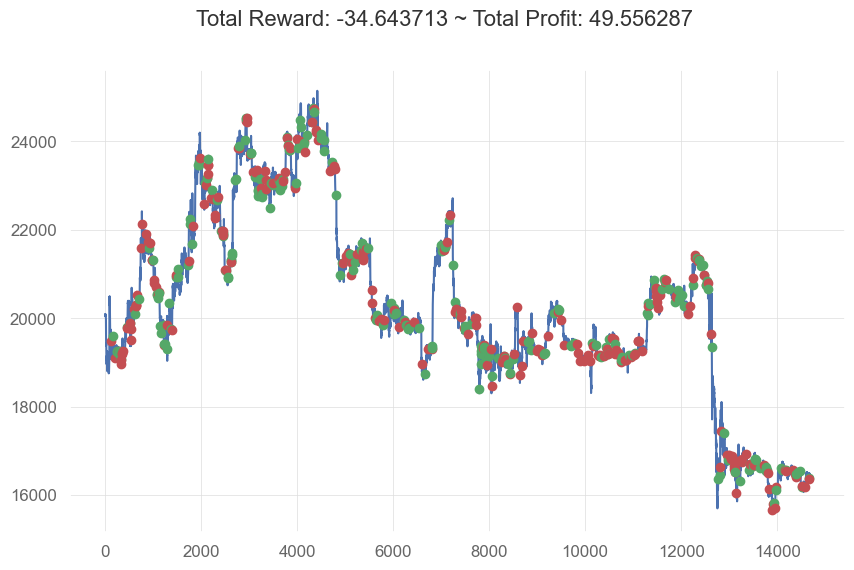

In [17]:
modelname = 'test220Lr=0.01'
dir_path = f"models\\{modelname}"  # Replace with the actual directory path
files = os.listdir(dir_path)

if files:  # Check if the directory contains any files
    newest_file = max(files, key=lambda x: os.path.getmtime(os.path.join(dir_path, x)))
    print(f'загружаю модель {newest_file}')

env = MyCustomEnv(df=enddf, frame_bound=(start_index+202,end_index), window_size=window_size)

profit = []
results = []
model = DQN.load(f'models\\{modelname}\\{newest_file}',env=env)

obs = env.reset()

while True:
    action, state = model.predict(obs)
    obs, reward, done, info = env.step(action)
    results.append(info['total_profit'])
    # rewards.append(reward)
    if done:
        break
    # profit.append(info['total_profit'])
# print(info['total_profit'])
plt.cla()
env.render_all()
plt.show()
# plt.scatter(range(len(rewards)), rewards)
# plt.show()


In [16]:
# results = pd.DataFrame(results)
# qs.extend_pandas()

# net_worth = pd.Series(results[0].values, index=traindf.index[start_index+203:end_index])
# returns = net_worth.iloc[1:]
# qs.reports.full(returns)